# Neural Machine Translation with attention
This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation. Since in the homework, we did some translation tasks from Spanish to English, I'd like to compare the method in homework and this nerual machine translation with attention method.
This notebook refers to the neural machine translation tutorial in tensorflow. https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

tf.enable_eager_execution()

## Download and prepare for the dataset
We can use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs. I will use the Chinese-English dataset.

In [0]:
# Download the file
if 'spa-eng.zip' not in os.listdir():
  !wget http://www.manythings.org/anki/spa-eng.zip
if 'spa.txt' not in os.listdir():
  !unzip spa-eng.zip

--2019-11-26 17:16:42--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4752884 (4.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   4.53M  5.03MB/s    in 0.9s    

2019-11-26 17:16:48 (5.03 MB/s) - ‘spa-eng.zip’ saved [4752884/4752884]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


In [0]:
# look into the data with some examples
!cat spa.txt | wc -l
!head -n 10 spa.txt

122936
Go.	Ve.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)
Go.	Vete.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)
Go.	Vaya.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)
Go.	Váyase.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)
Hi.	Hola.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)
Run!	¡Corre!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1685404 (Elenitigormiti)
Run!	¡Corran!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5213896 (cueyayotl)
Run!	¡Corra!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005613 (Seael)
Run!	¡Corred!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005615 (Seael)
Run.	Corred.	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #6681472 (arh)


In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
en_sentence = u'Run!'
cmn_sentence = u'¡Corre!'
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(cmn_sentence).encode('utf-8'))

<start> run ! <end>
b'<start> corre ! <end>'


In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
   
    return zip(*word_pairs)

In [0]:
en, sp, _ = create_dataset('spa.txt', None)
print(en[-1])
print(sp[-1])

<start> it may be impossible to get a completely error free corpus due to the nature of this kind of collaborative effort . however , if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning , we might be able to minimize errors . <end>
<start> puede que sea imposible obtener un corpus completamente libre de errores debido a la naturaleza de este tipo de esfuerzo de colaboracion . sin embargo , si animamos a los miembros a contribuir frases en sus propios idiomas en lugar de experimentar con los idiomas que estan aprendiendo , podriamos ser capaces de minimizar los errores . <end>


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang, _ = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
# Try experimenting with the size of that dataset
# num_examples = 50000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset('spa.txt')
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [0]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

98348 98348 24588 24588


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ('%d ----> %s' % (t, lang.index_word[t]))

In [0]:
print ('Input Language; index to word mapping')
convert(inp_lang, input_tensor_train[0])
print ()
print ('Target Language; index to word mapping')
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
10 ----> la
14162 ----> beca
27 ----> le
3729 ----> permitio
369 ----> estudiar
13 ----> en
6 ----> el
647 ----> extranjero
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> the
8324 ----> scholarship
5885 ----> enabled
51 ----> her
6 ----> to
323 ----> study
820 ----> abroad
3 ----> .
2 ----> <end>


In [0]:
# create tf.data dataset
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

## Write the encoder and decoder model

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

## Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
attention_layer = BahdanauAttention(10)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
checkpoint_dir = './drive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

## Translate

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

For the testing, I chose a short story from http://snappyspanish.com/beginner-spanish-it-cant-be-possible/.

Input: <start> es cierto , tu vida entera puede cambiar en un instante . <end>
Predicted translation: indeed , indeed your life can change in order . <end> 


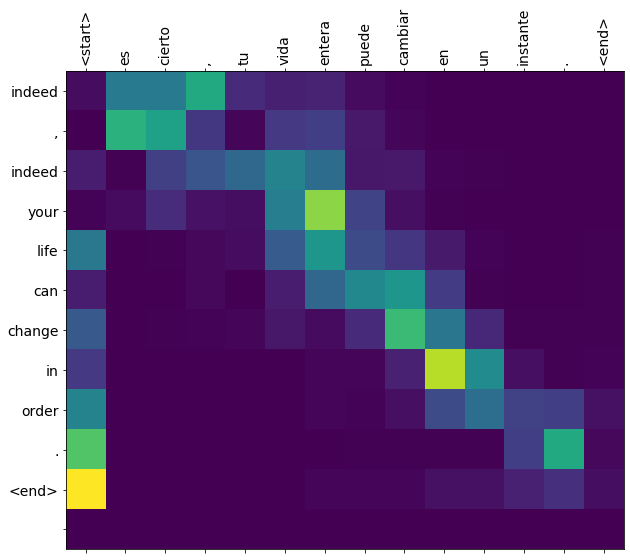

Gold: It’s true, your whole life can change in an instant.


In [0]:
translate(u'Es cierto, tu vida entera puede cambiar en un instante.')
print('Gold: It’s true, your whole life can change in an instant.')

Input: <start> en este momento estoy en la casa de mis padres . <end>
Predicted translation: i am at my house right now . <end> 


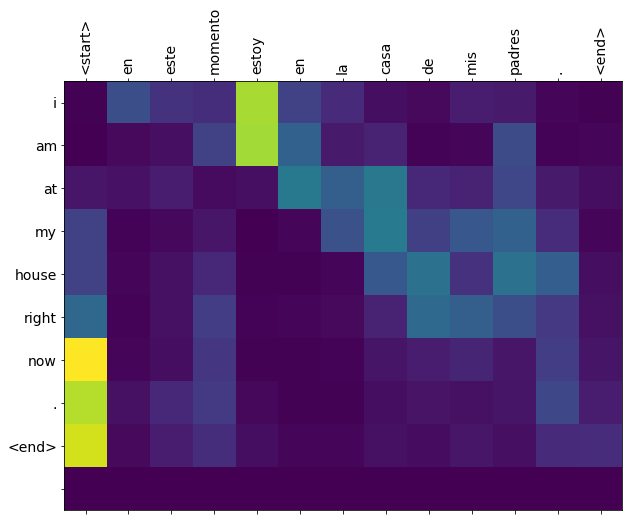

Gold: At the moment I’m at my parents house.


In [0]:
translate(u'En este momento estoy en la casa de mis padres.')
print('Gold: At the moment I’m at my parents house.')

Input: <start> solo veo a mis padres una vez al ano . <end>
Predicted translation: i only see my parents for one day . <end> 


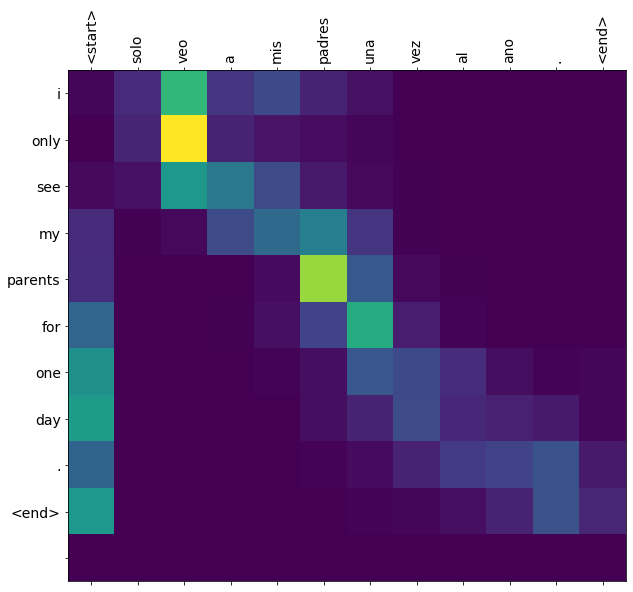

Gold: I only see my parents once a year.


In [0]:
translate(u'Solo veo a mis padres una vez al año.')
print('Gold: I only see my parents once a year.')

Input: <start> ellos viven al otro lado del pais . <end>
Predicted translation: they live on the other month . <end> 


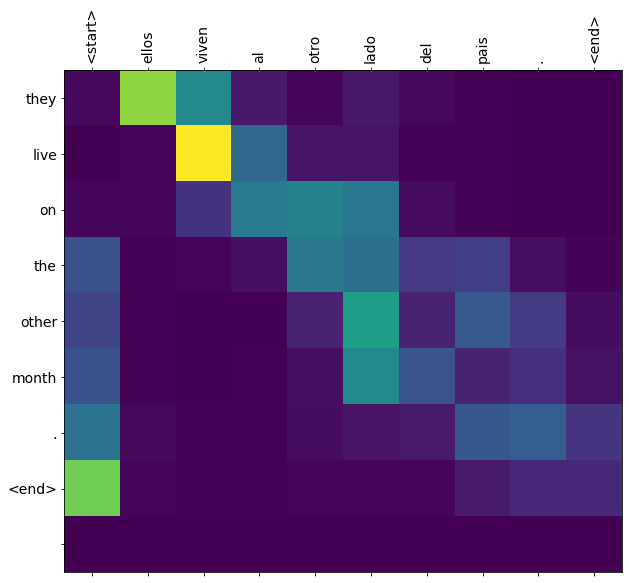

Gold: They live on the other side of the country.


In [0]:
translate(u'Ellos viven al otro lado del país.')
print('Gold: They live on the other side of the country.')

Input: <start> cuando estoy aca , me gusta ayudar mis padres . <end>
Predicted translation: when i m here , i want to help my parents . <end> 


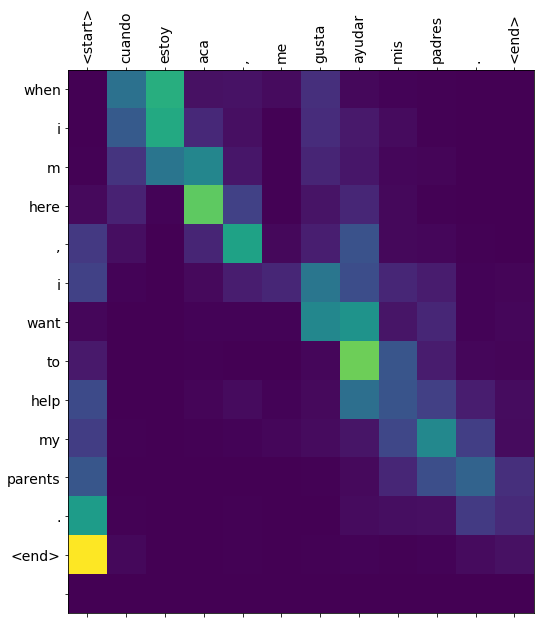

Gold: When I’m here, I like to help my parents.


In [0]:
translate(u'Cuando estoy acá, me gusta ayudar mis padres.')
print('Gold: When I’m here, I like to help my parents.')

Input: <start> a veces limpio , a veces lavo , a veces miro sus aburridos programas de television . <end>
Predicted translation: sometimes i sometimes i sometimes he often play soccer game . <end> 


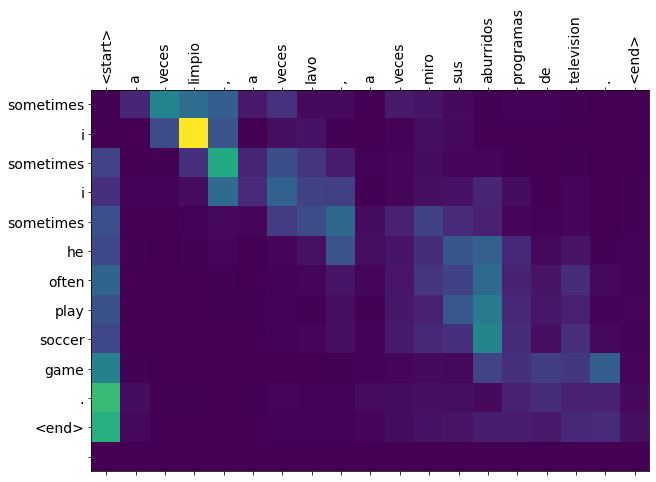

Gold: Sometimes I clean, sometimes I do the washing, sometimes I watch their boring tv shows.


In [0]:
translate(u'A veces limpio, a veces lavo, a veces miro sus aburridos programas de televisión.')
print('Gold: Sometimes I clean, sometimes I do the washing, sometimes I watch their boring tv shows.')

Input: <start> a mi madre le encanta leer . <end>
Predicted translation: my mother has read . <end> 


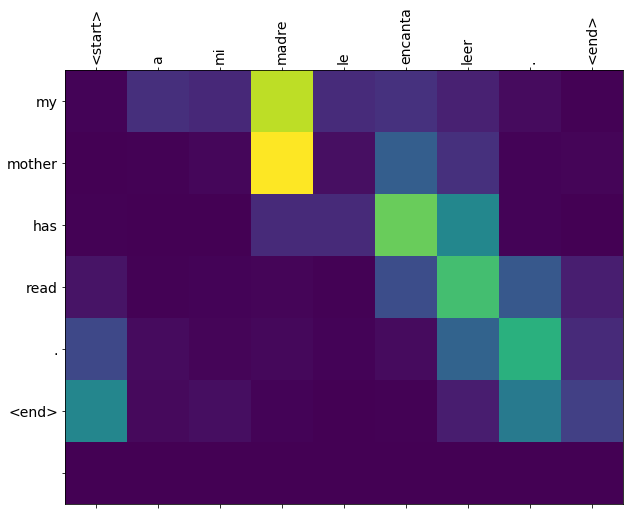

Gold: My mum loves to read. 


In [0]:
translate(u'A mi madre le encanta leer.')
print('Gold: My mum loves to read. ')

Input: <start> ella lee mucho . <end>
Predicted translation: she reads very much . <end> 


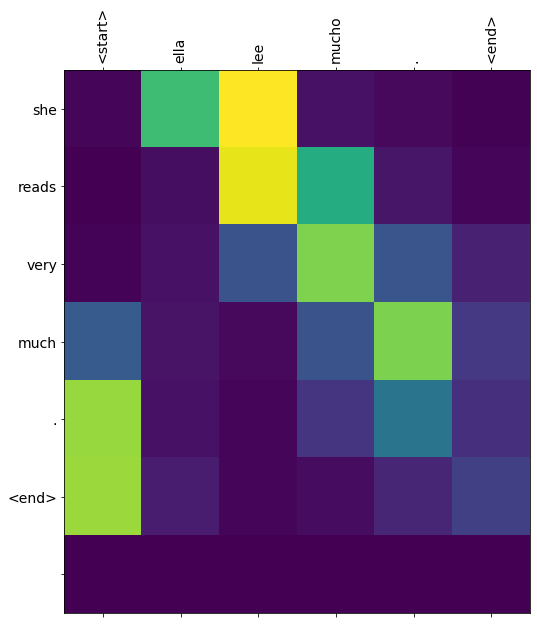

Gold: She reads a lot


In [0]:
translate(u'Ella lee mucho.')
print('Gold: She reads a lot')

Input: <start> hoy llevo sus libros de vuelta a la biblioteca . <end>
Predicted translation: today , i have my books on the library . <end> 


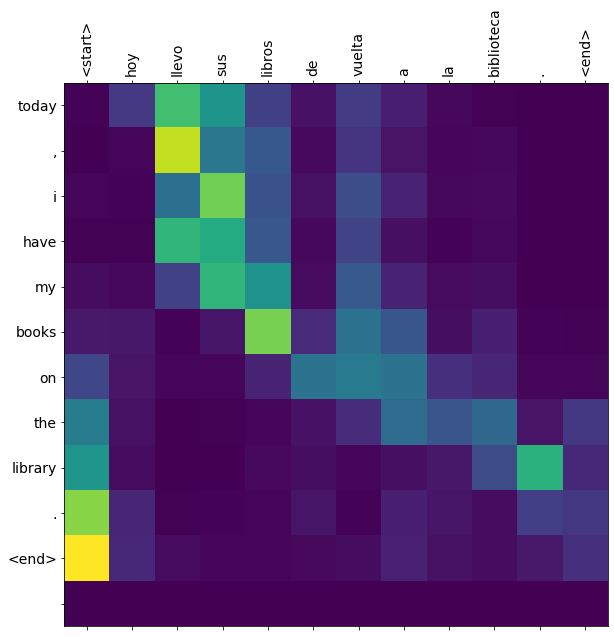

Gold: Today I take her books back to the library.


In [0]:
translate(u'Hoy llevo sus libros de vuelta a la biblioteca.')
print('Gold: Today I take her books back to the library.')

Input: <start> es un camino corto , solo quince minutos . <end>
Predicted translation: it s a road cold to fifteen minutes . <end> 


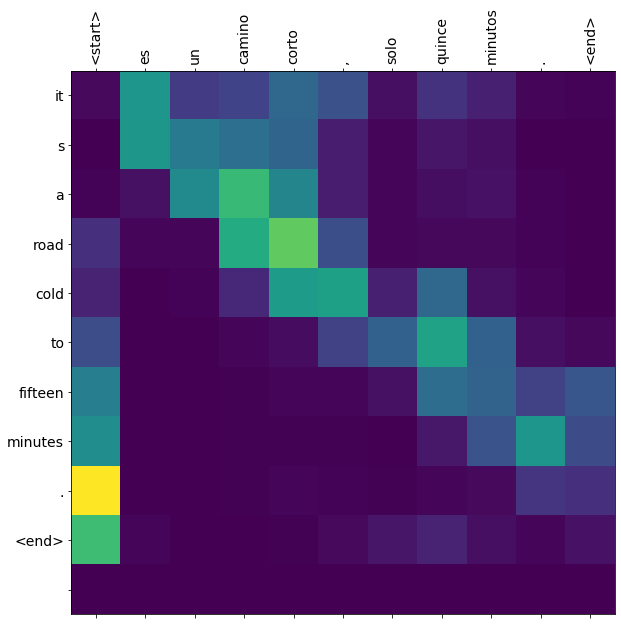

Gold: It’s a short walk, only fifteen minutes.


In [0]:
translate(u'Es un camino corto, solo quince minutos.')
print('Gold: It’s a short walk, only fifteen minutes.')

Input: <start> hay muchos libros . <end>
Predicted translation: there are many books . <end> 


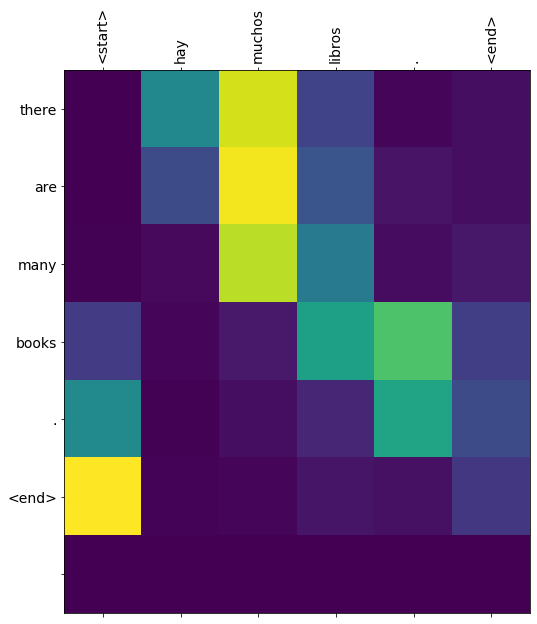

Gold: There are many books.


In [0]:
translate(u'Hay muchos libros.')
print('Gold: There are many books.')

Input: <start> cuando llego , mis brazos estan cansados . <end>
Predicted translation: when he got up to my age . <end> 


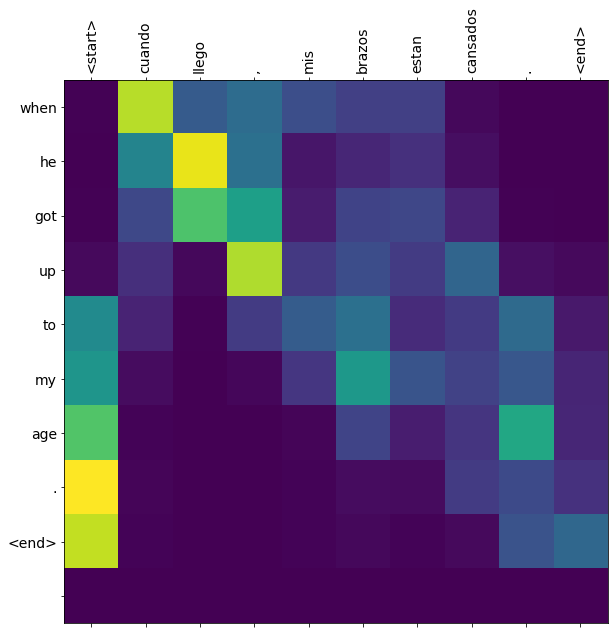

Gold: When I arrive, my arms are tired.


In [0]:
translate(u'Cuando llego, mis brazos estan cansados.')
print('Gold: When I arrive, my arms are tired.')

Input: <start> ella es una hermosa <end>
Predicted translation: she is a beautiful woman . <end> 


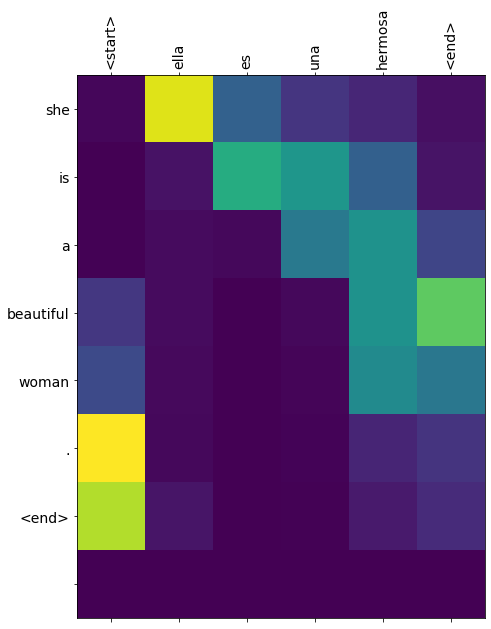

In [81]:
translate(u'ella es una hermosa')

Input: <start> el es alto <end>
Predicted translation: he is tall . <end> 


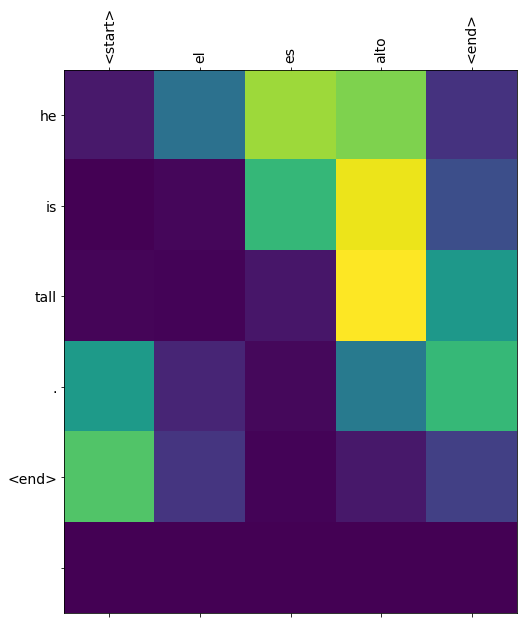

In [82]:
translate(u'El es alto')